In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as XGB
from scipy.stats import norm, skew

%matplotlib inline

In [180]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [181]:
train = pd.read_csv('train.csv')
test  =pd.read_csv('test.csv')

In [182]:
test_id = test['Id']

In [183]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [184]:
train.SalePrice.describe().transpose()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [185]:
y_train = train.SalePrice

In [186]:
train = train.drop('SalePrice', axis = 1)

In [187]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [188]:
full = pd.concat([train,test], axis = 0)

In [189]:
train.shape

(1460, 80)

In [190]:
full.shape

(2919, 80)

In [191]:
null_df = full.isnull().sum()

In [192]:
null_df = null_df[null_df > 0].sort_values()

C:\Users\Boris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


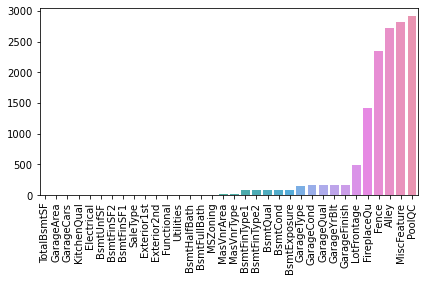

In [193]:
sns.barplot(null_df.index,null_df)

plt.xticks(rotation=90)
plt.tight_layout()

### We will drop columns with more than 1000 nan values

In [194]:
full.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis =1, inplace = True)

### We will fill None for NaN in some columns according to the data description file

In [195]:
null_df = full.isnull().sum()
null_df = null_df[null_df > 0].sort_values()
null_df.index

Index(['BsmtUnfSF', 'GarageArea', 'GarageCars', 'KitchenQual', 'Electrical',
       'TotalBsmtSF', 'BsmtFinSF2', 'BsmtFinSF1', 'SaleType', 'Exterior1st',
       'Exterior2nd', 'BsmtHalfBath', 'Utilities', 'Functional',
       'BsmtFullBath', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageType',
       'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'LotFrontage'],
      dtype='object')

In [196]:
cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
        ,'GarageType','GarageFinish','GarageQual','GarageCond']
for i in cols:
    full[i] = full[i].fillna('None')

In [197]:
null_df = full.isnull().sum()

In [198]:
null_df = null_df[null_df > 0].sort_values()

In [199]:
#Remaining null columns with counts
null_df

BsmtUnfSF         1
GarageCars        1
KitchenQual       1
Electrical        1
TotalBsmtSF       1
GarageArea        1
BsmtFinSF2        1
SaleType          1
Exterior2nd       1
Exterior1st       1
BsmtFinSF1        1
BsmtFullBath      2
BsmtHalfBath      2
Utilities         2
Functional        2
MSZoning          4
MasVnrArea       23
MasVnrType       24
GarageYrBlt     159
LotFrontage     486
dtype: int64

In [200]:
## Assuming that neighborhood should have similiar LotFrontage
full['LotFrontage'] = full.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [201]:
### Fill 0 for numerical object instead of none
full['GarageYrBlt'].fillna(0, inplace = True)
full['GarageArea'].fillna(0, inplace = True)
full['GarageCars'].fillna(0, inplace = True)

In [202]:
# MasVnrType: Masonry veneer type

#        BrkCmn	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        None	None
#        Stone	Stone

# MasVnrArea: Masonry veneer area in square feet
full['MasVnrType'].fillna('None', inplace = True)
full['MasVnrArea'].fillna(0, inplace = True)

In [203]:
# MSZoning: Identifies the general zoning classification of the sale.
		
#        A	Agriculture
#        C	Commercial
#        FV	Floating Village Residential
#        I	Industrial
#        RH	Residential High Density
#        RL	Residential Low Density
#        RP	Residential Low Density Park 
#        RM	Residential Medium Density
full['MSZoning'].fillna(full['MSZoning'].mode()[0], inplace = True)


In [204]:
# Functional: Home functionality (Assume typical unless deductions are warranted)

#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only

full['Functional'].fillna(full['Functional'].mode()[0], inplace = True)

In [205]:
# Utilities: Type of utilities available
		
#        AllPub	All public Utilities (E,G,W,& S)	
#        NoSewr	Electricity, Gas, and Water (Septic Tank)
#        NoSeWa	Electricity and Gas Only
#        ELO	Electricity only	

full['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [206]:
# Looks like it is dominant by AllPub, it wont be useful in predicting, so we will drop it anyway
del full['Utilities']

In [207]:
full['BsmtHalfBath'].value_counts()

0.0    2742
1.0     171
2.0       4
Name: BsmtHalfBath, dtype: int64

In [208]:
full['BsmtFullBath'].value_counts()

0.0    1705
1.0    1172
2.0      38
3.0       2
Name: BsmtFullBath, dtype: int64

In [209]:
full['TotalBsmtSF'].value_counts()

0.0       78
864.0     74
672.0     29
912.0     26
1040.0    25
768.0     24
816.0     23
728.0     20
1008.0    19
780.0     19
384.0     19
960.0     18
894.0     17
756.0     17
832.0     17
546.0     16
936.0     16
720.0     16
600.0     16
848.0     16
483.0     14
630.0     13
952.0     13
840.0     13
988.0     12
624.0     12
876.0     11
784.0     11
796.0     11
1056.0    10
884.0     10
928.0      9
858.0      9
738.0      9
855.0      9
896.0      8
970.0      8
990.0      8
992.0      8
1073.0     8
925.0      8
1728.0     8
926.0      7
847.0      7
1092.0     7
698.0      7
910.0      7
1362.0     7
660.0      7
684.0      7
572.0      7
1168.0     7
1216.0     7
793.0      7
1080.0     7
686.0      7
1100.0     7
882.0      7
845.0      7
1054.0     7
1200.0     7
1208.0     7
972.0      7
1158.0     6
680.0      6
547.0      6
1302.0     6
976.0      6
585.0      6
725.0      6
1405.0     6
1494.0     6
901.0      6
825.0      6
676.0      6
747.0      6
1152.0     6

In [210]:
full['BsmtUnfSF'].value_counts()

0.0       241
384.0      19
728.0      14
672.0      13
600.0      12
572.0      11
216.0      11
100.0      11
816.0      11
624.0      10
270.0      10
300.0      10
264.0       9
396.0       9
280.0       9
186.0       9
768.0       9
780.0       8
546.0       8
348.0       8
294.0       8
440.0       8
162.0       8
480.0       8
832.0       8
108.0       8
840.0       8
784.0       7
80.0        7
392.0       7
525.0       7
356.0       7
336.0       7
252.0       7
630.0       7
322.0       7
738.0       7
120.0       7
448.0       7
324.0       7
847.0       7
319.0       7
240.0       6
276.0       6
660.0       6
416.0       6
150.0       6
684.0       6
125.0       6
625.0       6
490.0       6
570.0       6
342.0       6
326.0       6
585.0       6
163.0       6
676.0       6
190.0       6
410.0       6
936.0       6
278.0       6
698.0       6
390.0       6
884.0       6
224.0       6
312.0       6
88.0        6
460.0       6
168.0       6
30.0        6
576.0       6
432.0 

In [211]:
full['BsmtFinSF2'].value_counts()

0.0       2571
294.0        5
180.0        5
162.0        3
539.0        3
168.0        3
147.0        3
144.0        3
483.0        3
374.0        3
435.0        3
182.0        2
174.0        2
210.0        2
202.0        2
273.0        2
117.0        2
712.0        2
288.0        2
41.0         2
105.0        2
116.0        2
344.0        2
596.0        2
110.0        2
492.0        2
72.0         2
465.0        2
469.0        2
252.0        2
287.0        2
354.0        2
290.0        2
276.0        2
159.0        2
127.0        2
551.0        2
468.0        2
121.0        2
270.0        2
495.0        2
60.0         2
108.0        2
279.0        2
264.0        2
96.0         2
480.0        2
247.0        2
670.0        2
40.0         2
80.0         2
64.0         2
128.0        2
400.0        2
620.0        2
240.0        2
93.0         2
841.0        2
42.0         2
590.0        2
391.0        2
68.0         2
723.0        2
500.0        1
850.0        1
479.0        1
306.0     

In [212]:
full['BsmtFinSF1'].value_counts()

0.0       929
24.0       27
16.0       14
300.0       9
288.0       8
384.0       8
600.0       8
20.0        8
602.0       7
500.0       7
700.0       7
360.0       7
456.0       7
936.0       7
375.0       7
624.0       7
560.0       6
312.0       6
528.0       6
504.0       6
662.0       6
547.0       6
468.0       6
368.0       6
544.0       6
553.0       6
120.0       6
276.0       6
625.0       6
588.0       6
732.0       5
758.0       5
196.0       5
450.0       5
904.0       5
767.0       5
595.0       5
104.0       5
637.0       5
336.0       5
330.0       5
697.0       5
1200.0      5
616.0       5
915.0       5
686.0       5
168.0       5
672.0       5
28.0        5
280.0       5
250.0       5
432.0       5
648.0       5
252.0       5
144.0       5
550.0       5
784.0       5
400.0       5
353.0       5
1000.0      4
1036.0      4
836.0       4
902.0       4
986.0       4
319.0       4
612.0       4
299.0       4
828.0       4
655.0       4
403.0       4
510.0       4
539.0 

In [213]:
### Nan Values that related to Basement are most likely none which is 0 in numerical columns, we will fill it by 0

In [214]:
full['BsmtHalfBath'].fillna(0, inplace = True)
full['BsmtFullBath'].fillna(0, inplace = True)
full['TotalBsmtSF'].fillna(0, inplace = True)
full['BsmtUnfSF'].fillna(0, inplace = True)
full['BsmtFinSF2'].fillna(0, inplace = True)
full['BsmtFinSF1'].fillna(0, inplace = True)

In [215]:
null_df = full.isnull().sum()
null_df = null_df[null_df > 0].sort_values()
null_df

Exterior1st    1
Exterior2nd    1
Electrical     1
KitchenQual    1
SaleType       1
dtype: int64

In [216]:
# SaleType: Type of sale
		
#        WD 	Warranty Deed - Conventional
#        CWD	Warranty Deed - Cash
#        VWD	Warranty Deed - VA Loan
#        New	Home just constructed and sold
#        COD	Court Officer Deed/Estate
#        Con	Contract 15% Down payment regular terms
#        ConLw	Contract Low Down payment and low interest
#        ConLI	Contract Low Interest
#        ConLD	Contract Low Down
#        Oth	Other
        
# KitchenQual: Kitchen quality

#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
       	
# Electrical: Electrical system

#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed

	
# Exterior2nd: Exterior covering on house (if more than one material)

#        AsbShng	Asbestos Shingles
#        AsphShn	Asphalt Shingles
#        BrkComm	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        CemntBd	Cement Board
#        HdBoard	Hard Board
#        ImStucc	Imitation Stucco
#        MetalSd	Metal Siding
#        Other	Other
#        Plywood	Plywood
#        PreCast	PreCast
#        Stone	Stone
#        Stucco	Stucco
#        VinylSd	Vinyl Siding
#        Wd Sdng	Wood Siding
#        WdShing	Wood Shingles


# Exterior1st: Exterior covering on house

#        AsbShng	Asbestos Shingles
#        AsphShn	Asphalt Shingles
#        BrkComm	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        CemntBd	Cement Board
#        HdBoard	Hard Board
#        ImStucc	Imitation Stucco
#        MetalSd	Metal Siding
#        Other	Other
#        Plywood	Plywood
#        PreCast	PreCast	
#        Stone	Stone
#        Stucco	Stucco
#        VinylSd	Vinyl Siding
#        Wd Sdng	Wood Siding
#        WdShing	Wood Shingles



In [217]:
full['SaleType'].fillna(full['SaleType'].mode()[0], inplace = True)
full['KitchenQual'].fillna(full['KitchenQual'].mode()[0], inplace = True)
full['Electrical'].fillna(full['Electrical'].mode()[0], inplace = True)
full['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0], inplace = True)
full['Exterior1st'].fillna(full['Exterior1st'].mode()[0], inplace = True)



### Drop ID

In [218]:
del full['Id']

### Separate Object and Int Columns

In [219]:
object_cols = [col for col in full.columns if full[col].dtype == "object"]

In [220]:
num_cols = [col for col in full.columns if full[col].dtype == "int64"]

In [221]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
for col in object_cols:
    full[col]=label_encoder.fit_transform(full[col])
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   int32  
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   int32  
 5   LotShape       2919 non-null   int32  
 6   LandContour    2919 non-null   int32  
 7   LotConfig      2919 non-null   int32  
 8   LandSlope      2919 non-null   int32  
 9   Neighborhood   2919 non-null   int32  
 10  Condition1     2919 non-null   int32  
 11  Condition2     2919 non-null   int32  
 12  BldgType       2919 non-null   int32  
 13  HouseStyle     2919 non-null   int32  
 14  OverallQual    2919 non-null   int64  
 15  OverallCond    2919 non-null   int64  
 16  YearBuilt      2919 non-null   int64  
 17  YearRemodAdd   2919 non-null   int64  
 18  RoofStyl

In [222]:
### Fix Screwness

In [223]:
skewed = full[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

In [224]:
skewed

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
EnclosedPorch     4.003891
ScreenPorch       3.946694
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
MSSubClass        1.375457
GrLivArea         1.269358
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
OverallCond       0.570312
BedroomAbvGr      0.326324
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
YrSold            0.132399
YearRemodAdd     -0.451020
YearBuilt        -0.599806
dtype: float64

In [225]:
skewed = skewed[abs(skewed) > 0.75]

In [226]:
for skew in skewed.index:
    full[skew] = np.log1p(full[skew])

In [227]:
X_train =full[:len(train)]
X_test = full[len(train):]

In [228]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,train_size = 0.66)

In [233]:
model =XGB.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model.fit(X_train, y_train)

[21:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=12, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [234]:
predictions = model.predict(x_test)

In [235]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = predictions
sub.to_csv('submission.csv',index=False)
sub.head(10)

,Id,SalePrice
0,1461,134943.734375
1,1462,162728.531250
2,1463,189146.593750
3,1464,198886.656250
4,1465,190938.609375
5,1466,174293.625000
6,1467,172059.531250
7,1468,164760.921875
8,1469,169439.187500
9,1470,127117.242188
